## AI Heart Disease Risk Predictor

## Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve
)
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import shap


In [2]:
%matplotlib inline


## Loading Dataset

In [3]:
df = pd.read_csv('/Users/praneethbadanapally/Desktop/UMassD/Spring 2025/DSC 550 Major Project/AI_HeartDiseasePrediction/data/raw/framingham_heart_study.csv')
print(df)

      male  age  education  currentSmoker  cigsPerDay  BPMeds  \
0        1   39        4.0              0         0.0     0.0   
1        0   46        2.0              0         0.0     0.0   
2        1   48        1.0              1        20.0     0.0   
3        0   61        3.0              1        30.0     0.0   
4        0   46        3.0              1        23.0     0.0   
...    ...  ...        ...            ...         ...     ...   
4235     0   48        2.0              1        20.0     NaN   
4236     0   44        1.0              1        15.0     0.0   
4237     0   52        2.0              0         0.0     0.0   
4238     1   40        3.0              0         0.0     0.0   
4239     0   39        3.0              1        30.0     0.0   

      prevalentStroke  prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  \
0                   0             0         0    195.0  106.0   70.0  26.97   
1                   0             0         0    250.0  121.0

In [4]:

print(df.shape) # No. of Rows & Columns

(4240, 16)


### Actual Column Names

In [5]:
print(df.columns)

Index(['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')


### Rename Column Names

In [6]:
df.rename(columns ={
    'male':'gender',
    'sysBP':'systolic_bp',
    'diaBP':'diastolic_bp'
},inplace =True)

### Updated Column Names

In [7]:
df.columns

Index(['gender', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'systolic_bp',
       'diastolic_bp', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')

### Checking Duplicate Values

In [8]:
df.duplicated().sum()

0

### Data type of Dataset

In [9]:
print(df.dtypes)

gender               int64
age                  int64
education          float64
currentSmoker        int64
cigsPerDay         float64
BPMeds             float64
prevalentStroke      int64
prevalentHyp         int64
diabetes             int64
totChol            float64
systolic_bp        float64
diastolic_bp       float64
BMI                float64
heartRate          float64
glucose            float64
TenYearCHD           int64
dtype: object


In [10]:
print(df.nunique())  # Check unique values


gender                2
age                  39
education             4
currentSmoker         2
cigsPerDay           33
BPMeds                2
prevalentStroke       2
prevalentHyp          2
diabetes              2
totChol             248
systolic_bp         234
diastolic_bp        146
BMI                1364
heartRate            73
glucose             143
TenYearCHD            2
dtype: int64


## Check for Missing Values in Dataset

In [11]:
print(df.isnull().sum())

gender               0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
systolic_bp          0
diastolic_bp         0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64


## Cleaning data

In [12]:
df.dropna(inplace=True)
print(df.isnull().sum())

gender             0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
systolic_bp        0
diastolic_bp       0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64


# Correlation Matrix

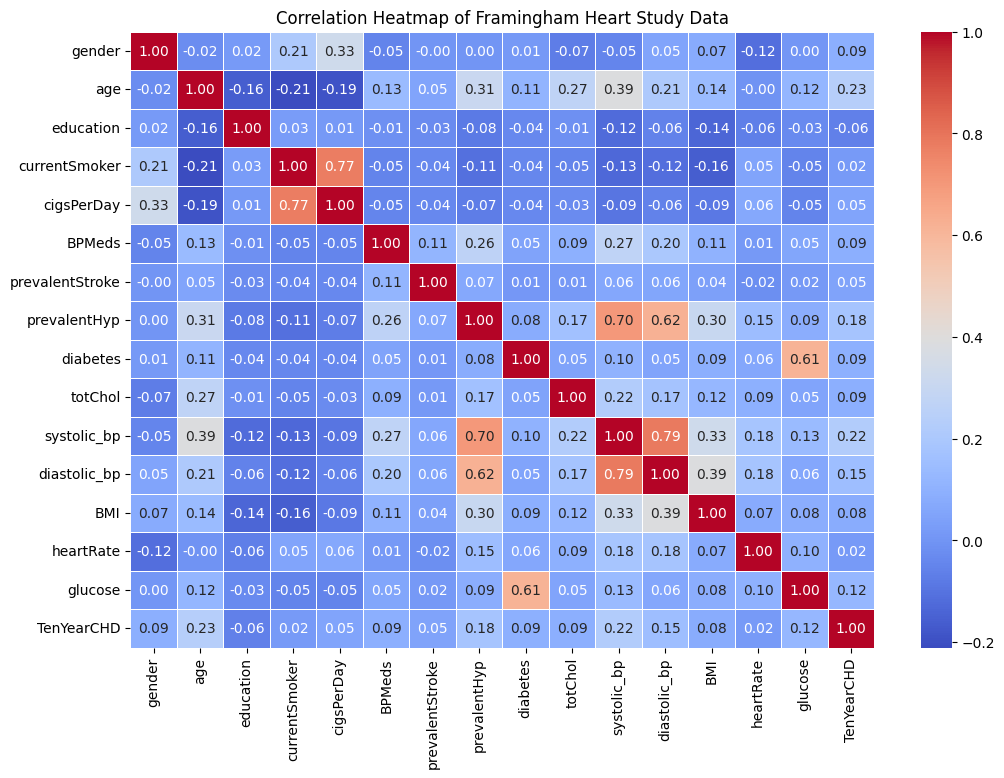

In [13]:
correlation_matrix = df.corr()

# Create the heatmap
plt.figure(figsize=(12, 8))  # Adjust the size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Show the plot
plt.title('Correlation Heatmap of Framingham Heart Study Data')
plt.show()


## Summary Statistics

In [14]:
df.describe()

,gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,systolic_bp,diastolic_bp,BMI,heartRate,glucose,TenYearCHD
count,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000
mean,0.443685,49.551941,1.980317,0.489065,9.025424,0.030344,0.005741,0.311646,0.027064,236.847731,132.370558,82.917031,25.782802,75.730727,81.852925,0.152269
std,0.496886,8.562029,1.022656,0.499949,11.921590,0.171557,0.075561,0.463229,0.162292,44.097681,22.086866,11.974258,4.065601,11.981525,23.904164,0.359331
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,113.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.080000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.380000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,143.875000,90.000000,28.037500,82.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,600.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


# Phase 2

## 2.1 EDA (Exploratory Data Analysis)

In [15]:
pio.renderers.default = 'notebook_connected'  # Enables inline display with HTML export

categorical_features = ['gender', 'currentSmoker', 'BPMeds', 'education',
                        'prevalentStroke', 'prevalentHyp', 'diabetes', 'TenYearCHD']

for feature in categorical_features:
    fig = px.histogram(df, x=feature, color=feature, barmode='group',
                       title=f"Distribution of {feature}",
                       labels={feature: feature, "count": "Frequency"},
                       color_discrete_sequence=px.colors.sequential.RdBu)

    fig.update_layout(
        xaxis_title=feature,
        yaxis_title="Frequency",
        legend_title=feature,
        bargap=0.2,
        template="plotly_white"
    )

    fig.show()


## CHD Proportion Pie Chart

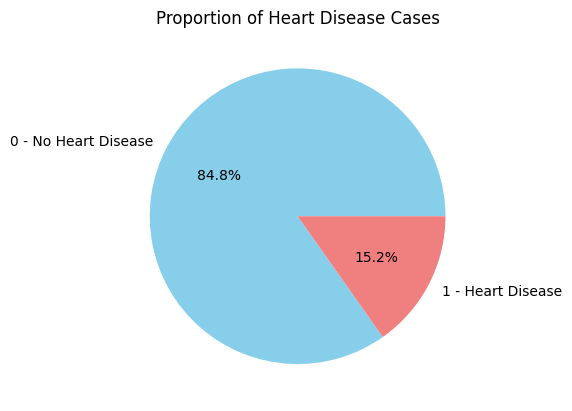

In [16]:
labels =["0 - No Heart Disease","1 - Heart Disease"]
df["TenYearCHD"].value_counts().plot(kind="pie",autopct="%1.1f%%",colors=["skyblue","lightcoral"],labels=labels)
plt.title("Proportion of Heart Disease Cases")
plt.ylabel("")
plt.show()

## Smoking Status vs CHD Risk

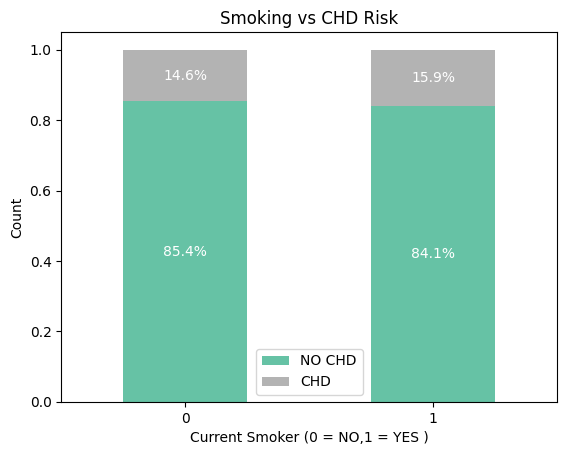

In [17]:
crosstab = pd.crosstab(df["currentSmoker"],df["TenYearCHD"],normalize = "index")
crosstab.plot(kind="bar",stacked = True, colormap ="Set2")
plt.title("Smoking vs CHD Risk")
plt.xlabel("Current Smoker (0 = NO,1 = YES )")
plt.ylabel("Count")
plt.legend(["NO CHD","CHD"])
plt.xticks(rotation =0)
for i in range(len(crosstab)):
    for j in range(len(crosstab.columns)):
        plt.text(i,crosstab.iloc[i,:j+1].sum() - (crosstab.iloc[i,j]/2),
                 f'{crosstab.iloc[i,j]*100:.1f}%',
                 ha = 'center',va ='center',color ='white', fontsize =10)
plt.show()

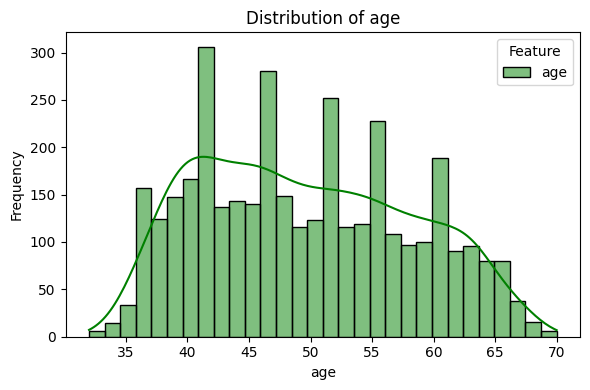

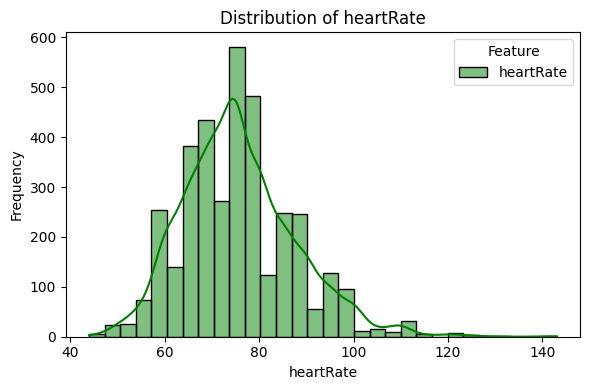

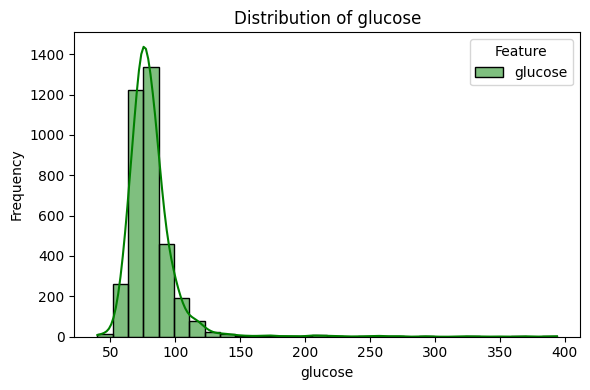

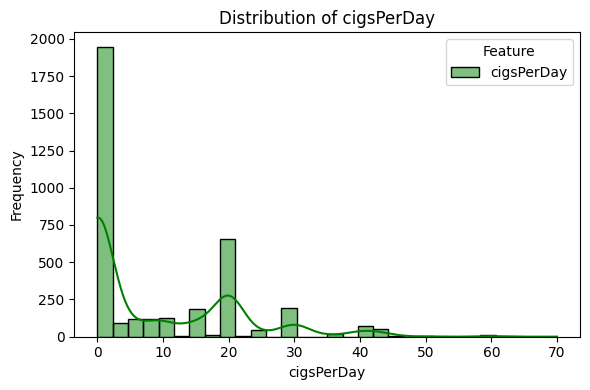

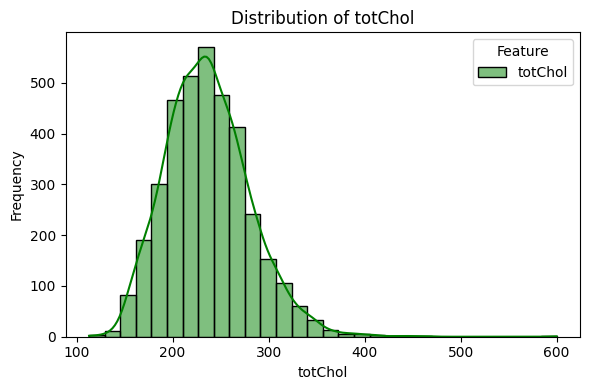

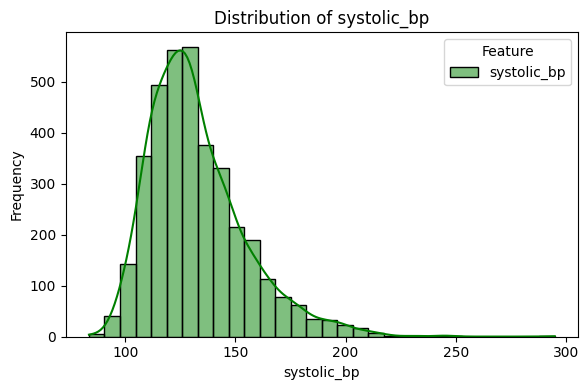

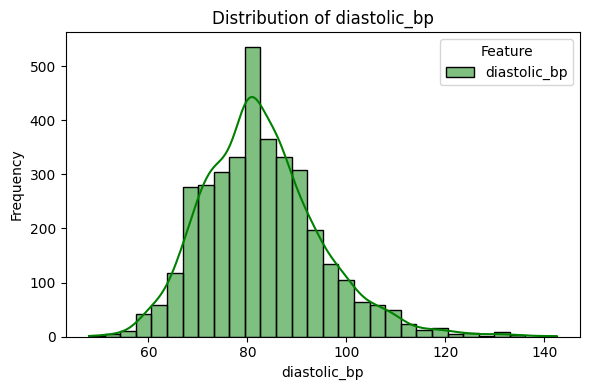

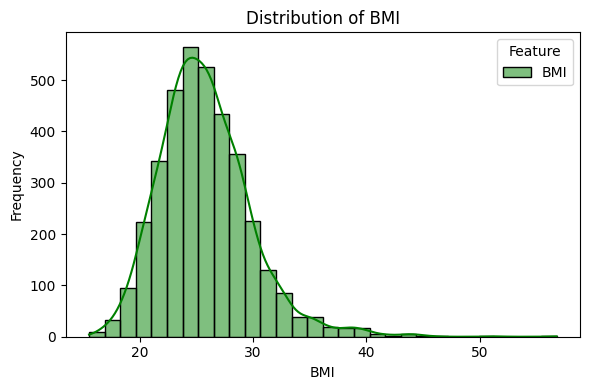

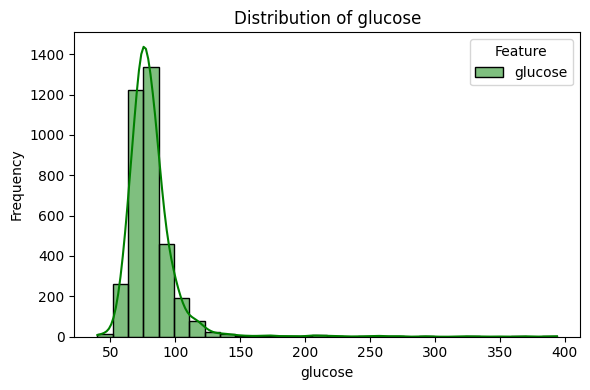

In [18]:


numerical_features = ['age','heartRate','glucose','cigsPerDay','totChol','systolic_bp','diastolic_bp','BMI','glucose']

for feature in numerical_features:
    fig = plt.figure(figsize=(6, 4))
    
    # Plot with label for legend
    sns.histplot(df[feature], bins=30, kde=True, color='green', label=feature)
    
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    
    # Add legend
    plt.legend(title="Feature")

    # Save figure
    filename = f"Distribution_of_{feature}.png"
    fig.savefig(filename)
    
    plt.tight_layout()
    plt.show()


## Box Plot for Outliers

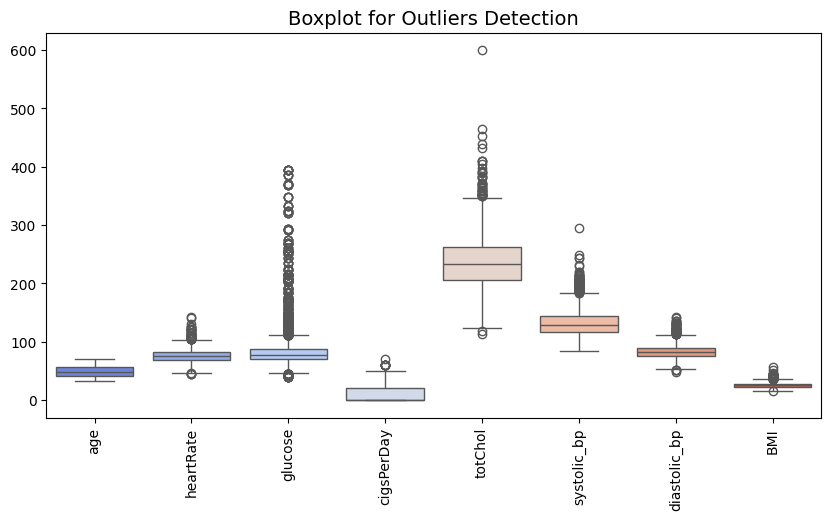

In [19]:
plt.figure(figsize =(10,5))
sns.boxplot(data =df[numerical_features],palette ='coolwarm')
plt.xticks(rotation = 90)
plt.title("Boxplot for Outliers Detection", fontsize =14)
plt.show()

## 2.2 Feature Engineering

In [20]:
print(df.columns)

Index(['gender', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'systolic_bp',
       'diastolic_bp', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')


In [27]:
# Pulse Pressure
df['pulsePressure']= df['systolic_bp']- df['diastolic_bp']
# Smoking Year
df["Smoking_Years"] = np.where(df["currentSmoker"]==1,df["age"]-21,0)

In [24]:
df.describe()

,gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,systolic_bp,diastolic_bp,BMI,heartRate,glucose,TenYearCHD,pulsePressure,Smoking_Years
count,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000
mean,0.443685,49.551941,1.980317,0.489065,9.025424,0.030344,0.005741,0.311646,0.027064,236.847731,132.370558,82.917031,25.782802,75.730727,81.852925,0.152269,49.453527,13.061782
std,0.496886,8.562029,1.022656,0.499949,11.921590,0.171557,0.075561,0.463229,0.162292,44.097681,22.086866,11.974258,4.065601,11.981525,23.904164,0.359331,14.666478,14.475310
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,113.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000,15.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.080000,68.000000,71.000000,0.000000,40.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.380000,75.000000,78.000000,0.000000,47.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,143.875000,90.000000,28.037500,82.000000,87.000000,0.000000,56.000000,25.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,600.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000,160.000000,48.000000


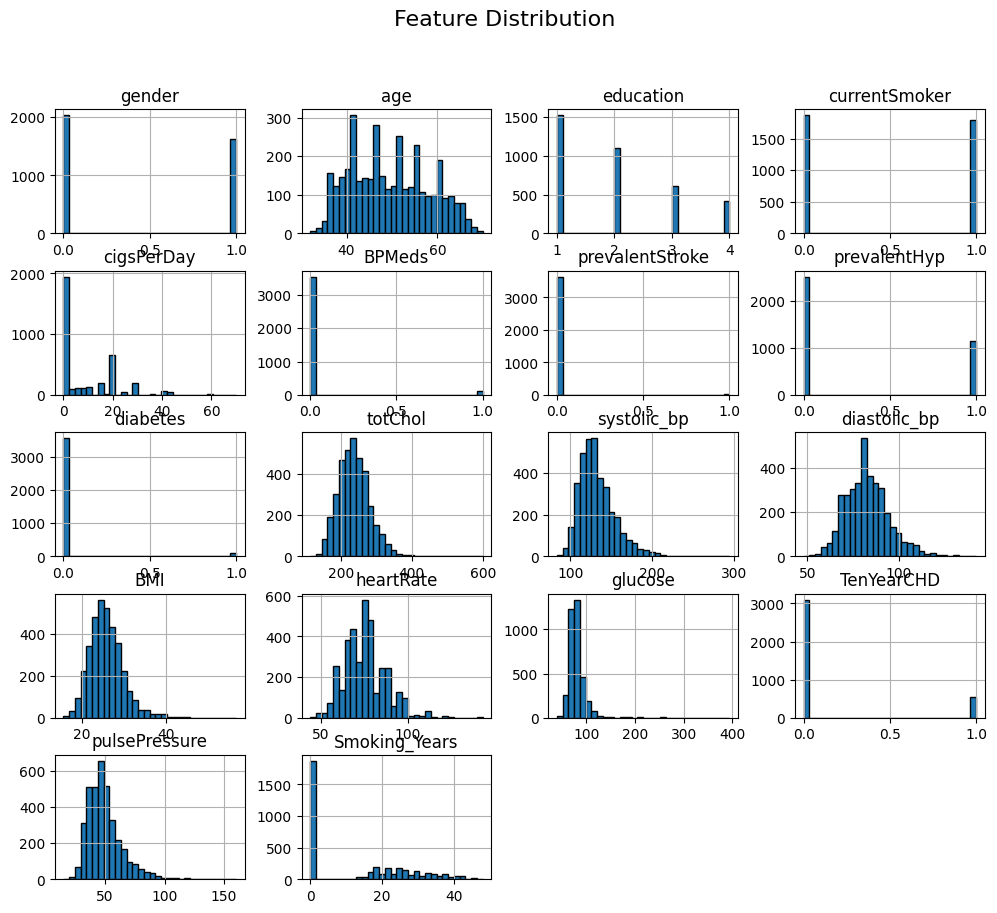

In [25]:
df.hist(figsize=(12,10),bins = 30, edgecolor = "black")
plt.suptitle("Feature Distribution", fontsize = 16)
plt.show()

In [26]:
df.columns

Index(['gender', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'systolic_bp',
       'diastolic_bp', 'BMI', 'heartRate', 'glucose', 'TenYearCHD',
       'pulsePressure', 'Smoking_Years'],
      dtype='object')

## Feature Encoding

In [28]:
#Binary encoding
binary_features = ['gender','currentSmoker','BPMeds','prevalentStroke','prevalentHyp','diabetes','TenYearCHD']
#ordinal encoding
education_mapping = {1:"Primary",2:"High School",3:"College",4:"Advanced Degree"}
df['education'] = df['education'].map(education_mapping)
education_order= {"Primary":1,"High School":2,"College":3,"Advanced Degree":4}
df['education'] = df['education'].map(education_order)
df = df.select_dtypes(include =[np.number])
df = df.dropna()

## Feature Scaling

In [28]:
df.columns

Index(['gender', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'systolic_bp',
       'diastolic_bp', 'BMI', 'heartRate', 'glucose', 'TenYearCHD',
       'pulsePressure', 'Smoking_Years'],
      dtype='object')

In [ ]:
scaler = StandardScaler()
numerical_features = ['age','totChol','systolic_bp','diastolic_bp','BMI','glucose','pulsePressure','cigsPerDay','he
df[numerical_features] = scaler.fit_transform(df[numerical_features])

## Saving Processed data

In [29]:
df.to_csv('/Users/praneethbadanapally/Desktop/UMassD/Spring 2025/DSC 550 Major Project/AI_HeartDiseasePrediction/data/processed/processed_framingham_heart_study.csv',index=False)
print("Processed Data Saved Successfully")

Processed Data Saved Successfully


In [21]:
df = pd.read_csv("/Users/praneethbadanapally/Desktop/UMassD/Spring 2025/DSC 550 Major Project/AI_HeartDiseasePrediction/data/processed/processed_framingham_heart_study.csv")

In [29]:
df

,gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,systolic_bp,diastolic_bp,BMI,heartRate,glucose,TenYearCHD,pulsePressure,Smoking_Years
0,1,39,4,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0,36.0,0
1,0,46,2,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0,40.0,0
2,1,48,1,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0,47.5,27
3,0,61,3,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1,55.0,40
4,0,46,3,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0,46.0,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3653,1,50,1,1,1.0,0.0,0,1,0,313.0,179.0,92.0,25.97,66.0,86.0,1,87.0,29
3654,1,51,3,1,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,68.0,0,46.5,30
3655,0,52,2,0,0.0,0.0,0,0,0,269.0,133.5,83.0,21.47,80.0,107.0,0,50.5,0
3656,1,40,3,0,0.0,0.0,0,1,0,185.0,141.0,98.0,25.60,67.0,72.0,0,43.0,0


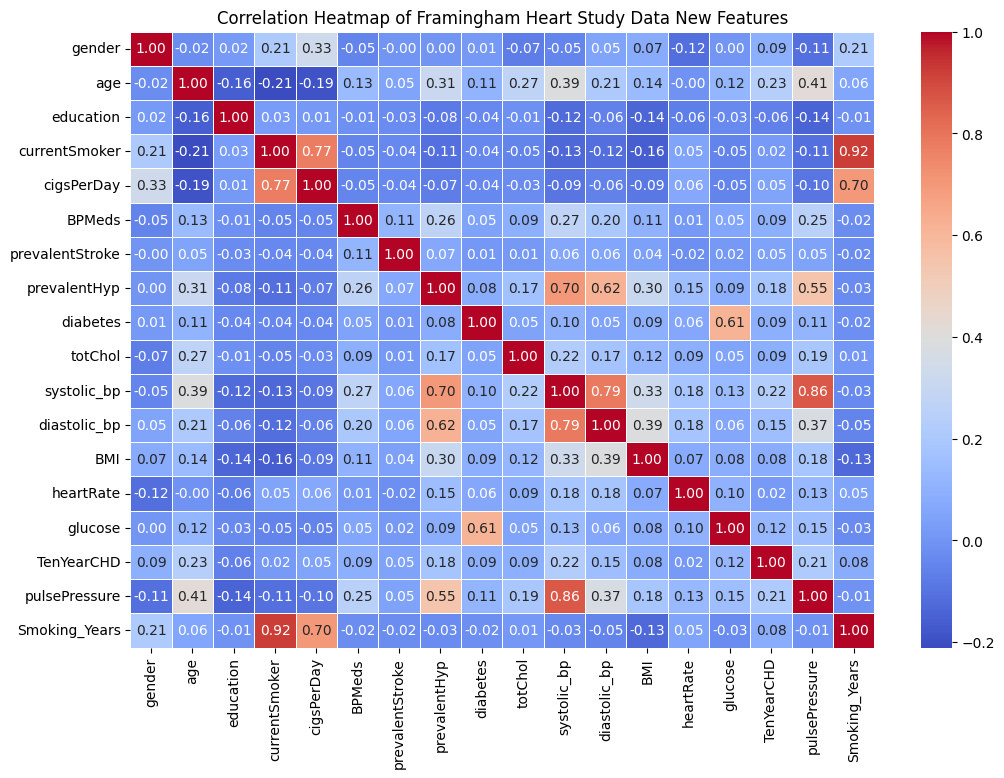

In [30]:
correlation_matrix = df.corr()

# Create the heatmap
plt.figure(figsize=(12, 8))  # Adjust the size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Show the plot
plt.title('Correlation Heatmap of Framingham Heart Study Data New Features')
plt.show()


In [31]:
print(df["TenYearCHD"].value_counts())

TenYearCHD
0    3101
1     557
Name: count, dtype: int64


# Phase 3

## Splitting data

In [39]:
df = pd.read_csv("/Users/praneethbadanapally/Desktop/UMassD/Spring 2025/DSC 550 Major Project/AI_HeartDiseasePrediction/data/processed/processed_framingham_heart_study.csv")
X = df.drop("TenYearCHD",axis =1)
Y = df['TenYearCHD']
X_train , X_test, Y_train, Y_test = train_test_split(X,Y,test_size =0.2, random_state = 42,stratify =Y)
numerical_features = ['age','totChol','systolic_bp','diastolic_bp','BMI','glucose','pulsePressure','cigsPerDay','heartRate','Smoking_Years']
scaler =StandardScaler()
X_train[numerical_features]= scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features]= scaler.transform(X_test[numerical_features])

print("Training Set Class Distribution", Y_train.value_counts())
print("Test Set Class Distribution", Y_test.value_counts())

Training Set Class Distribution TenYearCHD
0    2480
1     446
Name: count, dtype: int64
Test Set Class Distribution TenYearCHD
0    621
1    111
Name: count, dtype: int64


In [40]:
X_train

,gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,systolic_bp,diastolic_bp,BMI,heartRate,glucose,pulsePressure,Smoking_Years
3002,1,-1.339408,1,1,1.773460,0.0,0,0,0,1.005877,-0.974402,-0.863103,0.357993,1.582721,-0.073950,-0.759992,0.274917
863,1,-1.222966,2,0,-0.762076,0.0,0,0,0,0.233647,-0.883624,-0.241502,0.695479,0.346832,0.014026,-1.138132,-0.905993
2654,1,0.407231,3,1,0.928281,0.0,0,1,0,-0.742997,0.886540,-0.738783,-0.238151,0.182047,0.321945,1.955739,1.316897
363,0,-0.524310,2,0,-0.762076,0.0,0,1,0,1.528269,0.704985,1.913380,-0.686491,1.829898,-0.425858,-0.519358,-0.905993
704,0,-0.291425,2,1,0.083103,0.0,0,0,0,-1.038262,-0.338958,-0.863103,-0.482028,-0.065131,0.145992,0.202545,0.900105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,1,-1.572294,1,1,0.505692,0.0,0,0,0,1.437418,-1.382901,-1.360384,-0.021372,1.994684,0.805817,-0.966250,0.135987
1686,1,-0.407868,1,0,-0.762076,0.0,0,0,0,-0.334170,-0.543208,-0.780223,0.360456,0.099654,-0.953718,-0.175594,-0.905993
527,0,0.523673,1,0,-0.762076,0.0,0,1,0,1.142153,0.568819,0.670179,-0.482028,-0.641879,0.058015,0.305674,-0.905993
2187,0,-0.174982,3,1,-0.001415,0.0,0,1,0,0.665188,1.022707,1.416100,0.515651,-0.065131,0.102003,0.374427,0.969571


In [41]:
X_test

,gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,systolic_bp,diastolic_bp,BMI,heartRate,glucose,pulsePressure,Smoking_Years
3265,1,0.523673,3,1,1.773460,0.0,0,1,0,0.687900,0.409958,0.670179,-0.100201,1.335543,0.233968,0.065040,1.386363
1070,1,2.153870,1,0,-0.762076,0.0,0,0,0,-0.152468,-0.384347,-1.070303,-0.718515,-0.477094,-0.953718,0.305674,-0.905993
1179,0,-0.990081,2,1,0.928281,0.0,0,0,0,-0.038905,0.523430,0.421539,-0.395809,1.582721,0.014026,0.443180,0.483313
1758,1,0.057903,1,1,1.773460,0.0,0,0,0,-0.061618,-0.475125,-0.117182,0.954137,-0.971450,-0.249904,-0.622487,1.108501
2173,1,-1.339408,1,1,0.928281,0.0,0,0,0,-2.809850,-0.565902,0.048578,1.126575,0.182047,0.145992,-0.897497,0.274917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2446,0,0.290788,1,0,-0.762076,0.0,0,0,0,-0.652147,0.387263,0.172898,-0.225834,-0.065131,-0.601811,0.443180,-0.905993
2724,0,0.640116,1,0,-0.762076,0.0,0,0,0,2.141511,-0.202792,0.090018,-1.129904,-0.477094,-0.249904,-0.381852,-0.905993
3277,1,-1.688736,2,1,0.928281,0.0,0,0,0,-0.311457,-0.202792,-0.075742,-1.423049,0.346832,-0.645799,-0.244347,0.066521
3651,1,0.989444,3,0,-0.762076,0.0,0,1,0,-1.129113,0.387263,-0.158622,-0.198737,0.346832,-0.029962,0.718190,-0.905993


In [42]:
Y_train

3002    0
863     0
2654    0
363     0
704     0
       ..
1723    0
1686    0
527     0
2187    0
840     0
Name: TenYearCHD, Length: 2926, dtype: int64

In [43]:
Y_test

3265    1
1070    0
1179    0
1758    0
2173    0
       ..
2446    0
2724    0
3277    0
3651    0
2197    0
Name: TenYearCHD, Length: 732, dtype: int64

## SMOTE

In [45]:
smote = SMOTE(random_state=42)
X_train_res ,Y_train_res  = smote.fit_resample(X_train ,Y_train)

## ML model Development 

## Logistic Regression

In [46]:
lr = LogisticRegression()
lr.fit(X_train_res,Y_train_res)

LogisticRegression()

In [47]:
Y_test_pred_lr = lr.predict(X_test)
lr.score(X_test,Y_test)

0.6489071038251366

## Random Forest Model

In [48]:
rf = RandomForestClassifier(n_estimators =100, random_state = 42)
rf.fit(X_train_res,Y_train_res)
Y_pred_rf = rf.predict(X_test)


## Extreme Gradient Boost

In [49]:
xgb = XGBClassifier(
    objective="binary:logistic", eval_metric  ='logloss'
)
xgb.fit(X_train_res,Y_train_res)
Y_pred_xgb = xgb.predict(X_test)

## Light GBM Model

In [50]:

lgbm = LGBMClassifier(objective = "binary", random_state =42)
lgbm.fit(X_train_res,Y_train_res)
Y_pred_lgbm = lgbm.predict(X_test)


[LightGBM] [Info] Number of positive: 2480, number of negative: 2480
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2628
[LightGBM] [Info] Number of data points in the train set: 4960, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


## Catboost Model

In [51]:
catboost = CatBoostClassifier(verbose = 0,random_state =42)
catboost.fit(X_train_res,Y_train_res)
Y_pred_cat = catboost.predict(X_test)


## All ML models Performace Metrics

Logistic Regression Performance Metrics
Accuracy:0.65
Precision:0.24
Recall Score:0.59
ROC-AUC:0.6868
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.66      0.76       621
           1       0.24      0.59      0.34       111

    accuracy                           0.65       732
   macro avg       0.57      0.63      0.55       732
weighted avg       0.80      0.65      0.70       732

Random Forest Performance Metrics
Accuracy:0.79
Precision:0.29
Recall Score:0.27
ROC-AUC:0.6617
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.88      0.88       621
           1       0.29      0.27      0.28       111

    accuracy                           0.79       732
   macro avg       0.58      0.58      0.58       732
weighted avg       0.78      0.79      0.79       732

XGBoost Performance Metrics
Accuracy:0.79
Precision:0.23
Recall Score:0.16
ROC-AUC:0.6374
Classifica

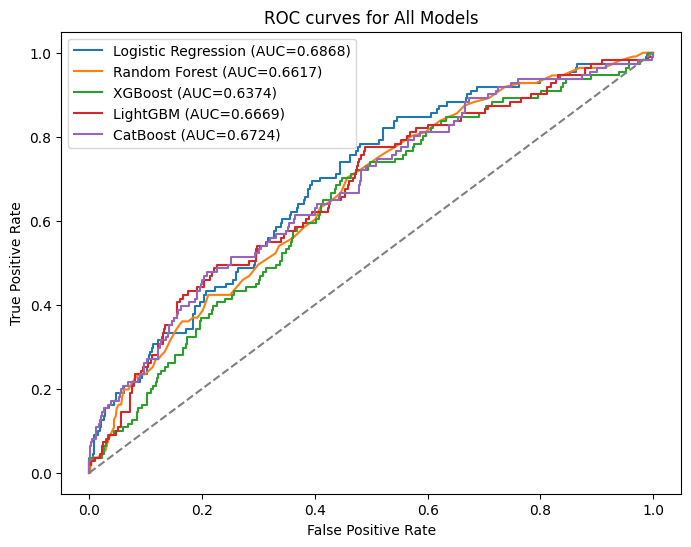

In [52]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators= 100, random_state = 42),
    "XGBoost":XGBClassifier(objective="binary:logistic", eval_metric  ='logloss'),
    "LightGBM":LGBMClassifier(),
    "CatBoost":CatBoostClassifier(verbose=0)
}
results ={}
plt.figure (figsize= (8,6))
for name, model in models.items():
    model.fit(X_train_res,Y_train_res)
    Y_pred = model.predict(X_test)
    Y_prob = model.predict_proba(X_test)[:,1]
    
    accuracy = accuracy_score(Y_test,Y_pred)
    precision = precision_score(Y_test,Y_pred)
    recall = recall_score(Y_test,Y_pred)
    roc_auc = roc_auc_score(Y_test,Y_prob)


    results[name] ={
    "Accuracy":accuracy,
    "Precision":precision,
    "Recall Score":recall,
    "ROC-AUC":roc_auc
    }
    print(f"{name} Performance Metrics")
    print(f"Accuracy:{accuracy:.2f}")
    print(f"Precision:{precision:.2f}")
    print(f"Recall Score:{recall:.2f}")
    print(f"ROC-AUC:{roc_auc:.4f}")
    print(f"Classification Report:\n", classification_report(Y_test,Y_pred))

    fpr,tpr,_= roc_curve(Y_test,Y_prob)
    plt.plot(fpr,tpr,label =f"{name} (AUC={roc_auc:.4f})")

plt.plot([0,1],[0,1],linestyle="--",color = "gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves for All Models")
plt.legend()
plt.show()

## Confusion Matrix for All ML models

[LightGBM] [Info] Number of positive: 2480, number of negative: 2480
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2628
[LightGBM] [Info] Number of data points in the train set: 4960, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


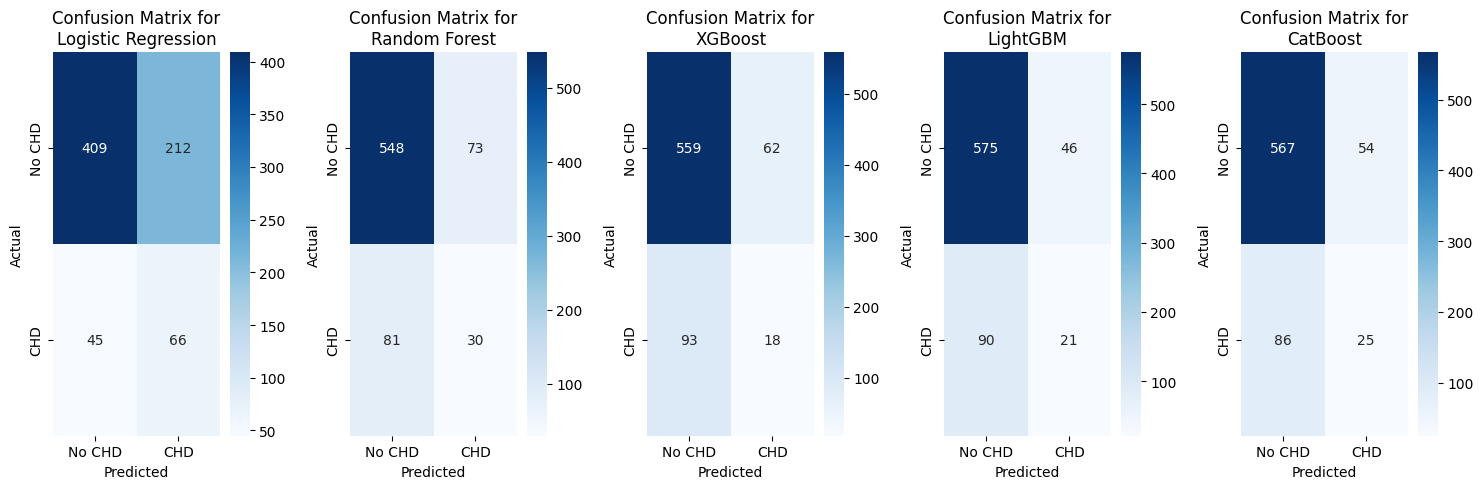

In [53]:
plt.figure(figsize=(15,5))
for i, (name,model) in enumerate(models.items()):
    model.fit(X_train_res,Y_train_res)
    Y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(Y_test,Y_pred)
    plt.subplot(1,len(models),i+1)
    sns.heatmap(conf_matrix,annot = True,fmt='d',cmap ='Blues',xticklabels=['No CHD','CHD'],yticklabels=['No CHD','CHD'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for\n{name}")

plt.subplots_adjust(wspace=0.5)  # horizontal space
plt.tight_layout()
plt.show()

## Confusion Matrix for Best ML model

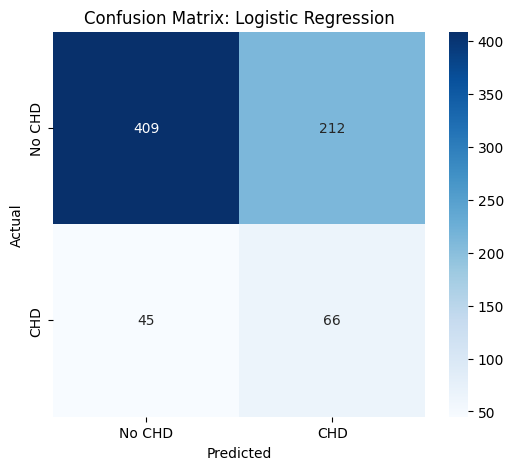

In [54]:
best_model_name = max(results,key=lambda x: results[x]["ROC-AUC"])
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(Y_test,y_pred_best),annot = True, fmt = 'd',cmap='Blues', xticklabels=['No CHD', 'CHD'], yticklabels=['No CHD', 'CHD'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix: {best_model_name}")
plt.show()

## Hyperparameter Tuning

### Grid Searcch CV for Logistic Regression

In [55]:

param_grid = {
    'C': [0.01,0.1,1,10,100],
    'penalty': ['l1','l2'],
    'solver': ['liblinear']
}
grid_Search = GridSearchCV(LogisticRegression(max_iter=1000),param_grid, cv=5, scoring ='roc_auc')
grid_Search.fit(X_train_res,Y_train_res)
best_lr = grid_Search.best_estimator_


### Predict on Test

In [56]:
Y_pred = best_lr.predict(X_test)
Y_prob = best_lr.predict_proba(X_test)[:,1]

## Evaluating Best Logistic Regression model

In [57]:
print("Best Hyperparameters : ", best_lr.get_params())
print("Accuracy : ", accuracy_score(Y_test,Y_pred))
print("Precision : ", precision_score(Y_test,Y_pred))
print("Recall : ", recall_score(Y_test,Y_pred))
print("ROC-AUC : ", roc_auc_score(Y_test,Y_prob))
print("Classification Report:", classification_report(Y_test,Y_pred))


Best Hyperparameters :  {'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Accuracy :  0.6516393442622951
Precision :  0.24285714285714285
Recall :  0.6126126126126126
ROC-AUC :  0.6921704313008661
Classification Report:               precision    recall  f1-score   support

           0       0.90      0.66      0.76       621
           1       0.24      0.61      0.35       111

    accuracy                           0.65       732
   macro avg       0.57      0.64      0.56       732
weighted avg       0.80      0.65      0.70       732



## Confusion Matrix of FIne Tuned Logistic Reggression Model

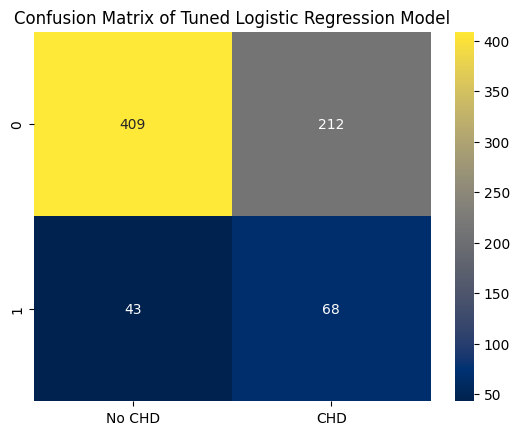

In [58]:
sns.heatmap(confusion_matrix(Y_test,Y_pred),annot = True, fmt ='d',cmap = 'cividis',xticklabels =["No CHD","CHD"])
plt.title("Confusion Matrix of Tuned Logistic Regression Model")
plt.show()




## ROC Curve

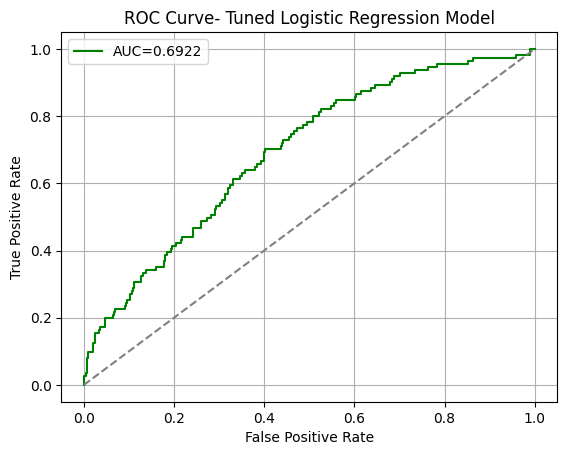

In [59]:
fpr, tpr, _= roc_curve(Y_test,Y_prob)
plt.plot(fpr,tpr, color='Green',label= f"AUC={roc_auc_score(Y_test,Y_prob):.4f}")
plt.plot([0,1],[0,1], linestyle ="--",color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve- Tuned Logistic Regression Model" )
plt.legend()
plt.grid(True)
plt.show()

In [60]:
# Reapply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, Y_train)


# GridSearch CV Hyperparameter Tuning for Random Forest

In [61]:

# Define hyperparameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Setup GridSearchCV
rf_grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit on the SMOTE-balanced training set
rf_grid_search.fit(X_train_res, y_train_res)

# Get best model
best_rf = rf_grid_search.best_estimator_

# Predict and evaluate
Y_pred_rf = best_rf.predict(X_test)
Y_prob_rf = best_rf.predict_proba(X_test)[:, 1]

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix
print("Best Random Forest Parameters:", rf_grid_search.best_params_)
print("Accuracy:", accuracy_score(Y_test, Y_pred_rf))
print("Precision:", precision_score(Y_test, Y_pred_rf))
print("Recall:", recall_score(Y_test, Y_pred_rf))
print("ROC-AUC:", roc_auc_score(Y_test, Y_prob_rf))
print("Classification Report:\n", classification_report(Y_test, Y_pred_rf))


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Random Forest Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Accuracy: 0.8005464480874317
Precision: 0.31958762886597936
Recall: 0.27927927927927926
ROC-AUC: 0.6696841769305537
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.89      0.88       621
           1       0.32      0.28      0.30       111

    accuracy                           0.80       732
   macro avg       0.60      0.59      0.59       732
weighted avg       0.79      0.80      0.79       732



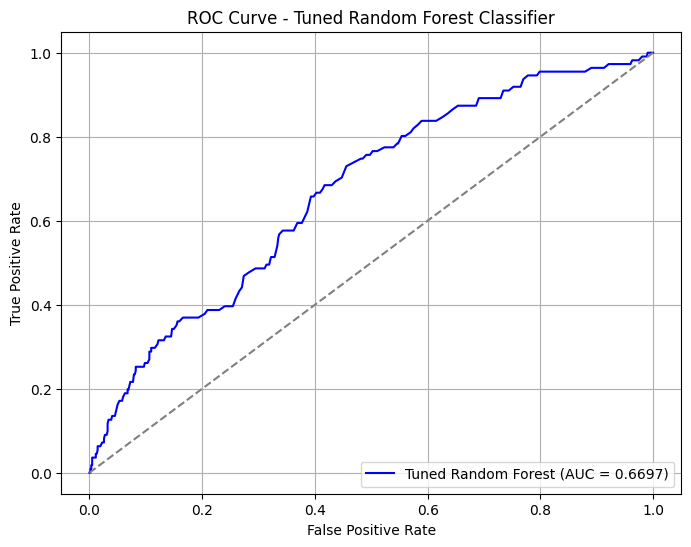

In [62]:
fpr, tpr, thresholds = roc_curve(Y_test, Y_prob_rf)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='Blue',label=f"Tuned Random Forest (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Tuned Random Forest Classifier")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Hyperparameter Tuning for XG Boost

In [63]:
# Make sure SMOTE is applied if not already
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, Y_train)

# Define hyperparameter grid
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Setup GridSearchCV
xgb_grid_search = GridSearchCV(
    estimator=XGBClassifier(objective='binary:logistic', eval_metric='logloss'),
    param_grid=xgb_param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit to SMOTE-balanced training data
xgb_grid_search.fit(X_train_res, y_train_res)

# Get the best model
best_xgb = xgb_grid_search.best_estimator_

# Predict on test set
Y_pred_xgb = best_xgb.predict(X_test)
Y_prob_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Evaluate
print("Best XGBoost Parameters:", xgb_grid_search.best_params_)
print("Accuracy:", accuracy_score(Y_test, Y_pred_xgb))
print("Precision:", precision_score(Y_test, Y_pred_xgb))
print("Recall:", recall_score(Y_test, Y_pred_xgb))
print("ROC-AUC:", roc_auc_score(Y_test, Y_prob_xgb))
print("Classification Report:\n", classification_report(Y_test, Y_pred_xgb))


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best XGBoost Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Accuracy: 0.8032786885245902
Precision: 0.273972602739726
Recall: 0.18018018018018017
ROC-AUC: 0.6590648619634127
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.89       621
           1       0.27      0.18      0.22       111

    accuracy                           0.80       732
   macro avg       0.57      0.55      0.55       732
weighted avg       0.77      0.80      0.79       732



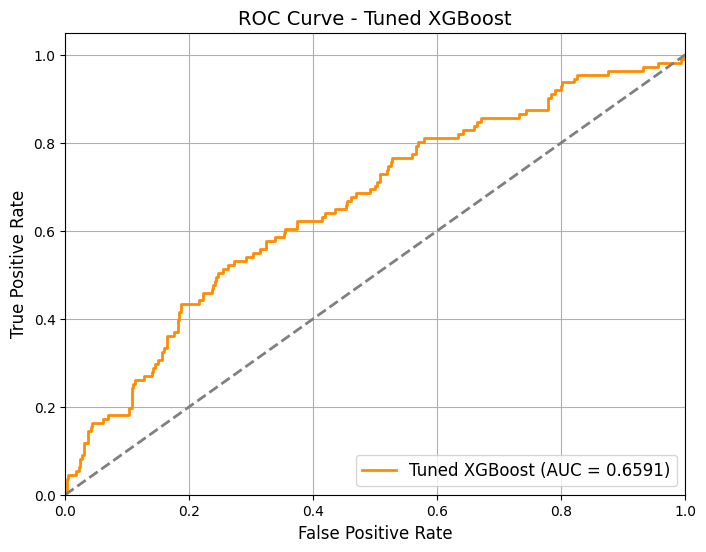

In [64]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve and AUC
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(Y_test, Y_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f"Tuned XGBoost (AUC = {roc_auc_xgb:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve - Tuned XGBoost", fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()


## SHAP Feature Importance Plot

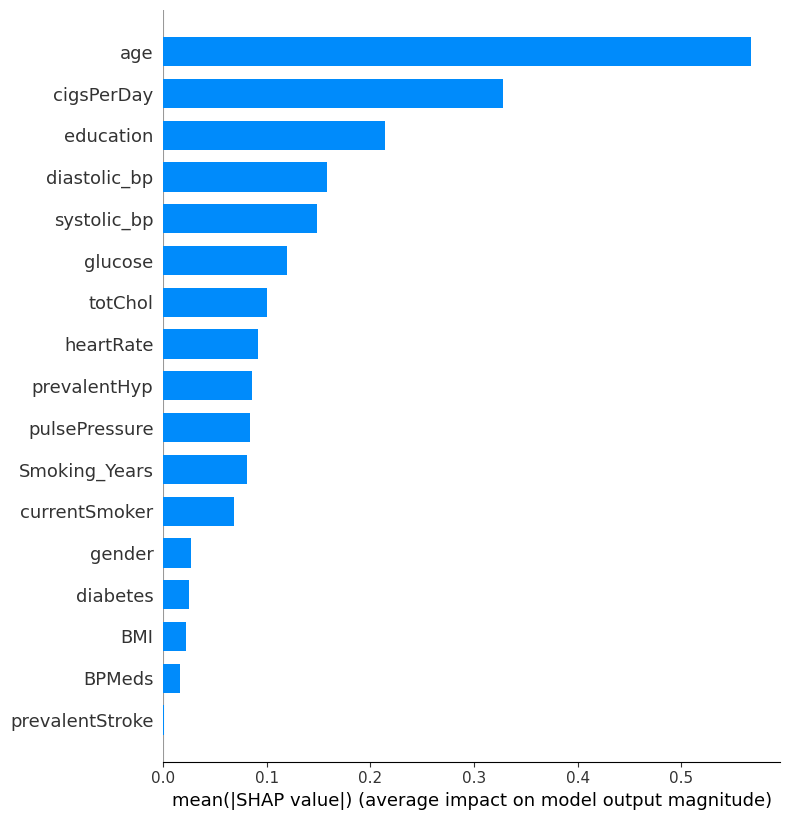

In [65]:
explainer = shap.Explainer(best_lr,X_train)

shap_values = explainer(X_test)

shap.summary_plot(shap_values,X_test,plot_type="bar")

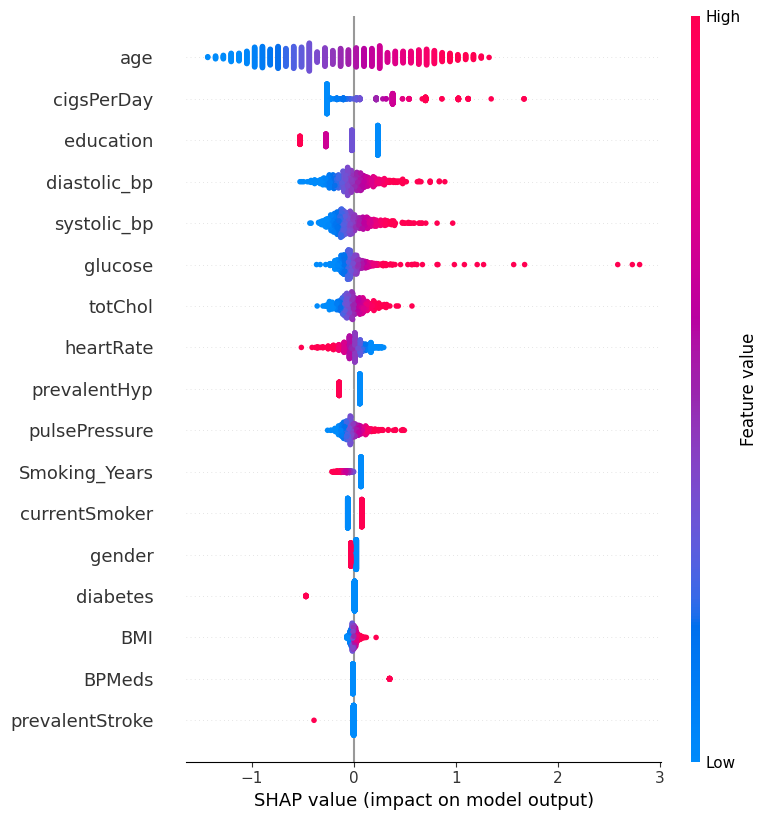

In [66]:
shap.summary_plot(shap_values, X_test)


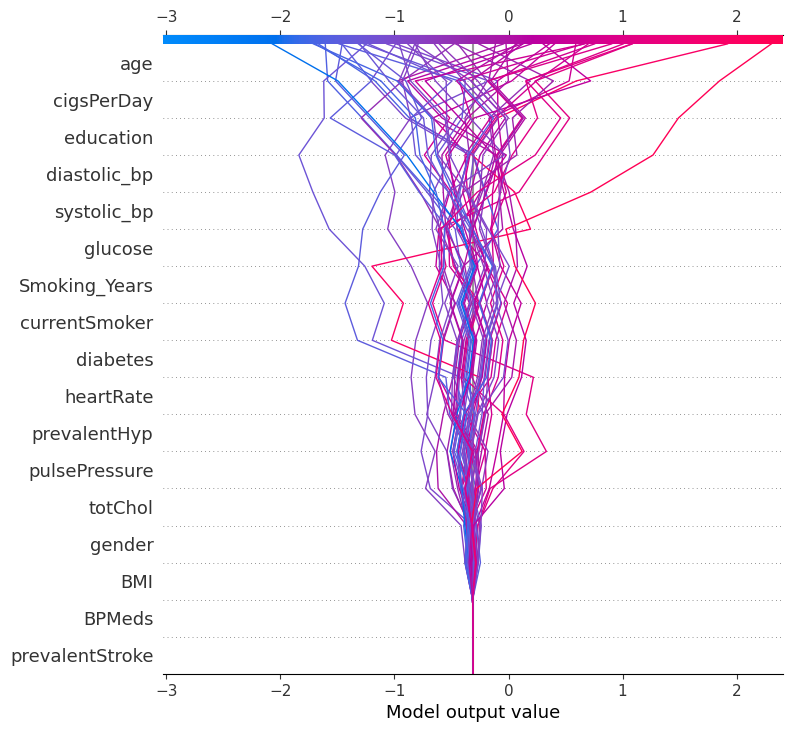

In [67]:
import shap

# 1. Create explainer and shap values
explainer = shap.Explainer(best_model, X_test)
shap_values = explainer(X_test)

# 2. Correct Decision Plot
shap.plots.decision(
    base_value=explainer.expected_value, 
    shap_values=shap_values.values[:50],   # <== THIS IS IMPORTANT
    features=X_test.iloc[:50]
)


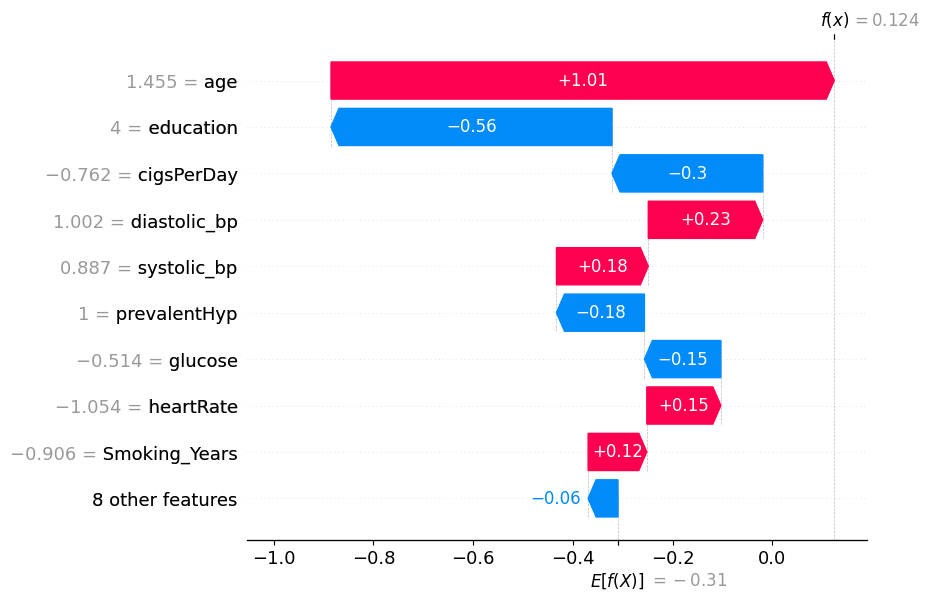

In [68]:
shap.plots.waterfall(shap_values[5])


## Finalizing ML Model

In [65]:
import joblib

# Paths
lr_path = "/Users/praneethbadanapally/Desktop/UMassD/Spring 2025/DSC 550 Major Project/AI_HeartDiseasePrediction/models/logistic_regression_model.pkl"

# Save tuned Logistic Regression
joblib.dump(best_lr, lr_path)

print("Tuned Logistic Regression model saved successfully.")


Tuned Logistic Regression model saved successfully.


In [66]:
print("Train accuracy:", model.score(X_train, Y_train))
print("Test accuracy:", model.score(X_test, Y_test))


Train accuracy: 0.9275461380724539
Test accuracy: 0.8087431693989071


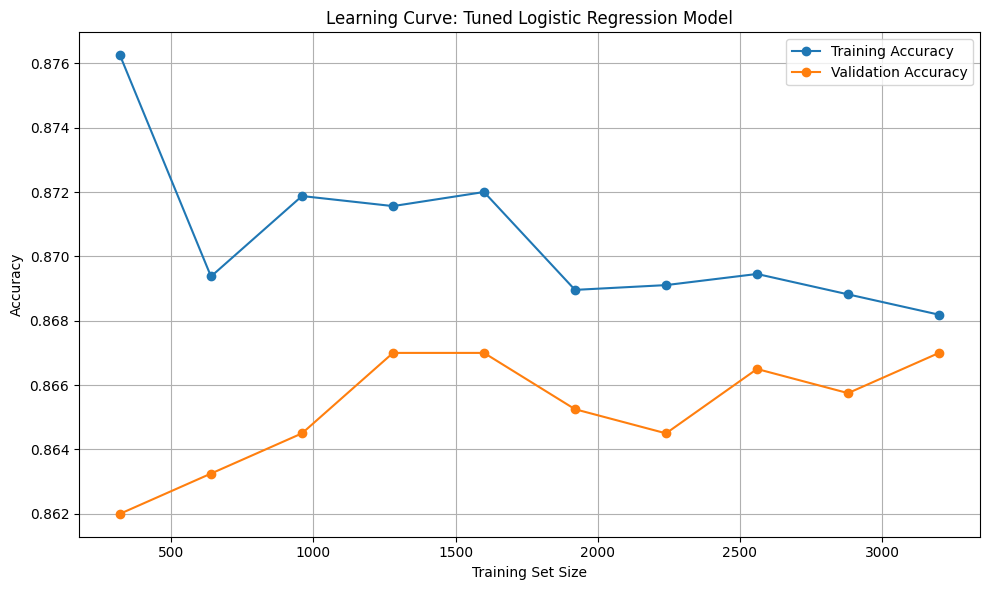

In [67]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
import joblib

# Load model
model = joblib.load("/Users/praneethbadanapally/Desktop/UMassD/Spring 2025/DSC 550 Major Project/AI_HeartDiseasePrediction/models/logistic_regression_model.pkl")

# Assume you have access to X_train and Y_train (needed to compute learning curve)
# We'll simulate some split for demonstration here (real code assumes you have it loaded)
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

# Generate dummy if not available
X, y = make_classification(n_samples=5000, n_features=17, random_state=42)
X_train, _, Y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)

# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model,
    X=X_train,
    y=Y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

# Calculate means
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy')
plt.plot(train_sizes, test_mean, 'o-', label='Validation Accuracy')
plt.title('Learning Curve: Tuned Logistic Regression Model')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
